In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from tqdm.auto import tqdm

from capstone.utils import set_plot_style

warnings.filterwarnings("ignore")
set_plot_style()

In [2]:
def read_file(path, name, index_col=None):
    return pd.read_csv(f"{path}/{name}.csv", index_col=index_col, parse_dates=True)

data_dir = "data"
snp = "snp_prices"
indices = "indices"
stocks_sectors = "stocks_by_sector"

snp_prices = read_file(data_dir, snp, index_col="Date")
indices_prices = read_file(data_dir, indices, index_col="Date")
sectors = read_file(data_dir, stocks_sectors, index_col=0)

In [3]:
snp_prices.head(3)

,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2006-02-06,21.155682,27.594042,2.040143,13.528105,6.003333,23.419563,39.520000,25.989521,19.771849,22.702063,...,60.795563,13.990589,34.024216,9.861901,33.966381,23.323494,13.171959,58.793865,43.349998,58.166370
2006-02-07,20.705034,27.339506,2.049237,13.429254,5.937778,23.639191,39.259998,26.118898,19.871237,22.846333,...,61.587666,13.916323,33.315826,9.714868,33.188068,23.336805,13.014937,59.287476,44.000000,57.862595
2006-02-08,21.033888,28.272818,2.085917,13.413301,5.885556,23.749002,38.799999,26.455246,20.288673,23.258522,...,62.731754,13.990589,33.167553,9.615091,33.276222,23.394472,12.865635,59.613647,46.180000,58.307129


In [4]:
snp_prices.shape

(4429, 419)

In [5]:
indices_prices.head(3)

,BONDS,COMMODITIES,STOCKS,VOLATILITY
Date,,,,
2006-02-06,58.718147,21.916014,45.468452,13.04
2006-02-07,58.677162,21.282080,45.025742,13.59
2006-02-08,58.647850,21.191517,45.349682,12.83


In [6]:
indices_prices.shape

(4429, 4)

In [7]:
indices_log_returns = np.log(indices_prices).diff()[1:]
snp_log_returns = np.log(snp_prices).diff()[1:]

In [8]:
snp_log_returns.head(3)

,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2006-02-07,-0.021532,-0.009267,0.004448,-0.007334,-0.010980,0.009334,-0.006601,0.004966,0.005014,0.006335,...,0.012945,-0.005322,-0.021040,-0.015022,-0.023181,0.000571,-0.011993,0.008361,0.014883,-0.005236
2006-02-08,0.015758,0.033568,0.017741,-0.001189,-0.008834,0.004635,-0.011786,0.012795,0.020789,0.017881,...,0.018406,0.005322,-0.004460,-0.010324,0.002653,0.002468,-0.011538,0.005486,0.048357,0.007653
2006-02-09,0.016938,0.011932,-0.057730,0.002137,0.006210,-0.021814,-0.017681,0.000244,0.021965,0.010797,...,-0.024426,-0.001148,-0.013837,0.017863,-0.007813,0.033927,-0.014104,0.012052,-0.006517,0.007091


In [9]:
indices_log_returns.head(3)

,BONDS,COMMODITIES,STOCKS,VOLATILITY
Date,,,,
2006-02-07,-0.000698,-0.029352,-0.009784,0.041313
2006-02-08,-0.000500,-0.004264,0.007169,-0.057548
2006-02-09,0.000599,0.009358,-0.001907,0.022352


In [10]:
features = indices_log_returns.copy()
available_tickers = snp_log_returns.columns.to_list()

for sector in sectors["GICS Sector"].unique():
    sector_stocks_all = sectors[sectors["GICS Sector"] == sector]["Symbol"].to_list()
    available_sector_stocks = [stock for stock in sector_stocks_all if stock in available_tickers]
    sector_constituent_returns = snp_log_returns[available_sector_stocks].mean(axis=1)
    features[f"{sector.upper().replace(' ', '_')}"] = sector_constituent_returns

lookback = 10

for col in features.columns:
    rolling_mean_return = features[col].rolling(lookback).mean() * 252
    rolling_std = features[col].rolling(lookback).std() * np.sqrt(252)
    features[f"{col}_SHARPE"] = rolling_mean_return / rolling_std

for col in features.columns:
    for i in range(63, 252, 63):
        features[f"{col}_LAG_{int(i/63)}Q"] = features[col].shift(i)

features = features.dropna()

display(features.head(3))
print(features.shape)

,BONDS,COMMODITIES,STOCKS,VOLATILITY,INDUSTRIALS,HEALTH_CARE,INFORMATION_TECHNOLOGY,COMMUNICATION_SERVICES,CONSUMER_STAPLES,UTILITIES,...,MATERIALS_SHARPE_LAG_3Q,REAL_ESTATE_SHARPE_LAG_1Q,REAL_ESTATE_SHARPE_LAG_2Q,REAL_ESTATE_SHARPE_LAG_3Q,CONSUMER_DISCRETIONARY_SHARPE_LAG_1Q,CONSUMER_DISCRETIONARY_SHARPE_LAG_2Q,CONSUMER_DISCRETIONARY_SHARPE_LAG_3Q,ENERGY_SHARPE_LAG_1Q,ENERGY_SHARPE_LAG_2Q,ENERGY_SHARPE_LAG_3Q
Date,,,,,,,,,,,,,,,,,,,,,
2006-11-17,0.002596,0.012310,-0.000504,-0.010886,-0.004459,0.001046,-0.005078,-0.000377,-0.002317,0.001344,...,1.238707,2.352655,-10.954340,6.042028,1.685617,-10.963118,2.596329,-2.995603,-10.017998,-2.960267
2006-11-20,0.000697,-0.003677,0.000576,-0.007992,-0.003779,-0.002129,0.004160,-0.000719,-0.000648,0.000208,...,5.142295,5.941873,-12.178404,10.780372,2.674236,-12.469288,9.141953,-1.349365,-11.089592,-1.268225
2006-11-21,0.001294,0.009371,0.002587,-0.007046,0.005667,0.000498,0.000011,0.004655,-0.001240,0.001681,...,5.186143,6.481492,-13.063038,11.395211,3.692904,-13.196869,6.680954,-5.148571,-14.467737,-1.102505


(4230, 120)


In [11]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(df):
    results = {}
    for col in tqdm(df.columns):
        adf_test = adfuller(df[col], autolag='AIC')
        p_value = adf_test[1]
        results[col] = "Stationary" if p_value < 0.05 else "Non-Stationary"
        
    return pd.Series(results)

In [12]:
stationarity_test = test_stationarity(features)

for result in stationarity_test.values:
    assert result == "Stationary"

  0%|          | 0/120 [00:00<?, ?it/s]

In [13]:
df = features.copy()

df.to_csv("data/master_df.csv")

In [14]:
unique_sectors = sectors["GICS Sector"].unique()
unique_sectors = set([sec.upper().replace(" ", "_") for sec in unique_sectors])
sector_names = [col for col in df.columns if col in unique_sectors]

X = df[sector_names]
y = df[df.columns[~df.columns.isin(X.columns)]]

Text(0.5, 1.0, 'Feature Correlations')

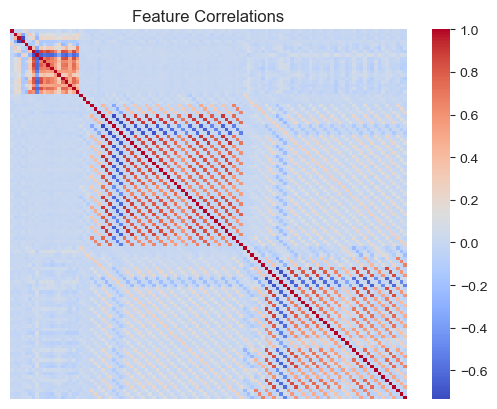

In [15]:
sns.heatmap(y.corr(), cmap="coolwarm")
plt.xticks([])
plt.yticks([])
plt.title("Feature Correlations")